In [1]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

# Load images from a directory
def load_images_from_folder(path, img_size, maxImgsPerClass=None, maxClasses=None):
    images = []
    labels = []
    classes = []
    filesPerClass = []
    index = 0
    
    folders = os.listdir(path)

    for folder in folders:
        if folder == '.DS_Store': continue
        imgCounter = 0
        for filename in sorted(os.listdir(os.path.join(path, folder))):
            img_path = os.path.join(path, folder, filename)
            img = Image.open(img_path).resize((img_size, img_size)).convert('L')
            img_array = np.array(img)
            images.append(img_array)
            labels.append([index])
            imgCounter += 1
            
            if maxImgsPerClass is not None and imgCounter == maxImgsPerClass:
                break
            
        classes.append(folder)
        filesPerClass.append(imgCounter)       
        index = index + 1;
        
        if maxClasses is not None and index == maxClasses:
            break;
            
    return np.array(images), np.array(labels), np.array(classes), np.array(filesPerClass)

def show_images(images, labels, classes, number):
    plt.figure(figsize=(10, 3))
    for i in range(number):
      rnd = random.randint(0, len(images))
      image = images[rnd]
      true_label = classes[labels[rnd]]
      plt.subplot( int(number/5), 5, i + 1)
      plt.imshow(image, cmap='gray')
      plt.title(f'{true_label}', fontsize=10)
      plt.axis('off')
    plt.tight_layout()
    plt.show()

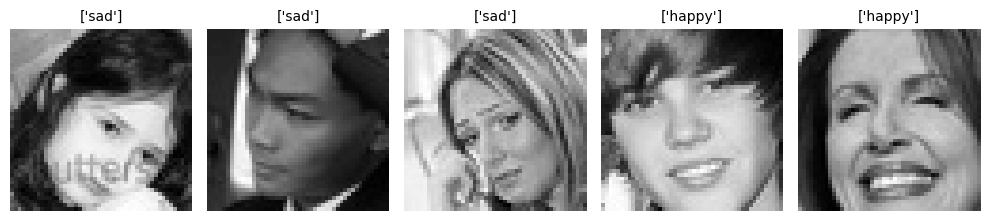

In [3]:
train_folder = '../datasets/facial-expressions/train'
test_folder = '../datasets/facial-expressions/test'

img_size = 48  # sets the image size

# load images and classes
train, train_labels, classes, train_count = load_images_from_folder(train_folder, img_size, maxImgsPerClass=None, maxClasses=2)
test, test_labels, classes_test, test_count = load_images_from_folder(test_folder, img_size, maxImgsPerClass=None, maxClasses=2)

show_images(train, train_labels, classes, 5)

Exploratory Analyses

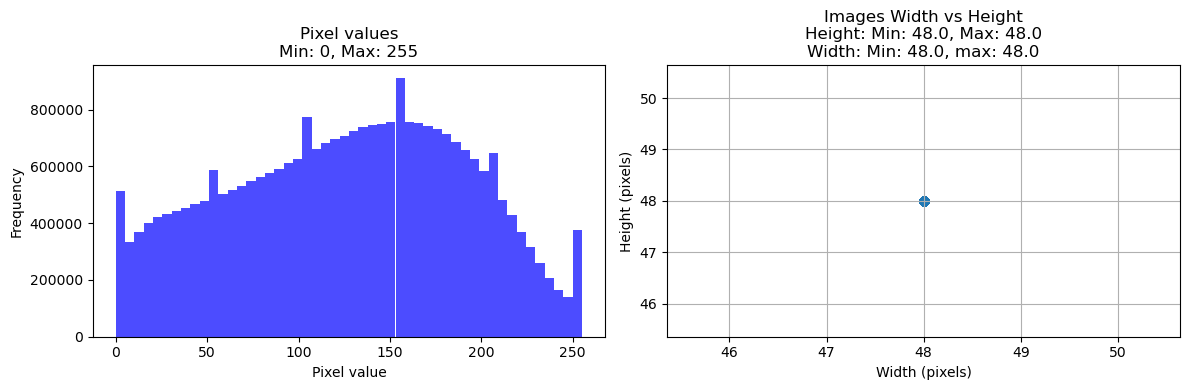

In [5]:
# Get min and max pixel values
pixel_min = np.min(train)
pixel_max = np.max(train)

# Get image dimension
image_heights = train.shape[1] * np.ones(train.shape[0])
image_widths = train.shape[2] * np.ones(train.shape[0])

# Plot min and max pixel values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Pixel values\nMin: {pixel_min}, Max: {pixel_max}')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

# Plot width and heights
plt.subplot(1, 2, 2)
plt.scatter(image_widths, image_heights, alpha=0.5)
plt.title(f'Images Width vs Height\nHeight: Min: {image_heights.min()}, Max: {image_heights.max()}\nWidth: Min: {image_widths.min()}, max: {image_widths.max()}')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)

plt.tight_layout()
plt.show()


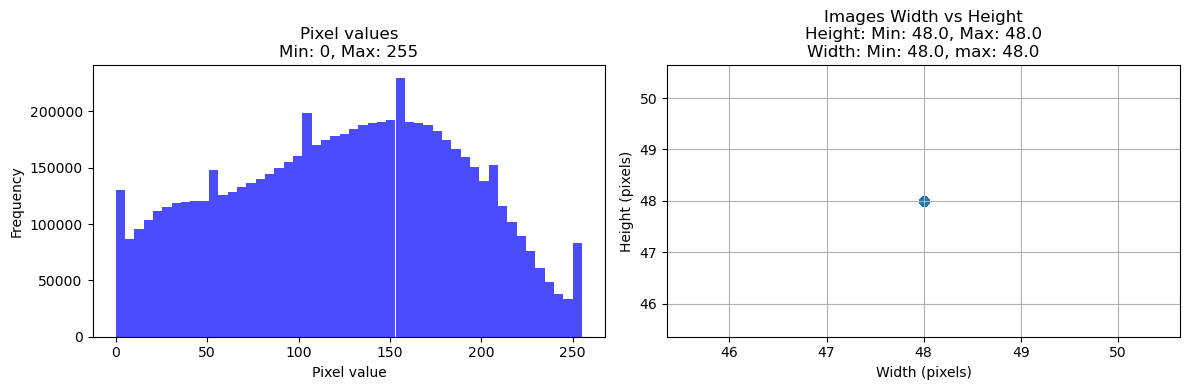

In [6]:
# Get min and max pixel values
pixel_min = np.min(test)
pixel_max = np.max(test)

# Get image dimension
image_heights = test.shape[1] * np.ones(test.shape[0])
image_widths = test.shape[2] * np.ones(test.shape[0])

# Plot min and max pixel values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(test.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Pixel values\nMin: {pixel_min}, Max: {pixel_max}')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

# Plotar gráfico de dispersão de largura vs altura
plt.subplot(1, 2, 2)
plt.scatter(image_widths, image_heights, alpha=0.5)
plt.title(f'Images Width vs Height\nHeight: Min: {image_heights.min()}, Max: {image_heights.max()}\nWidth: Min: {image_widths.min()}, max: {image_widths.max()}')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)

plt.tight_layout()
plt.show()

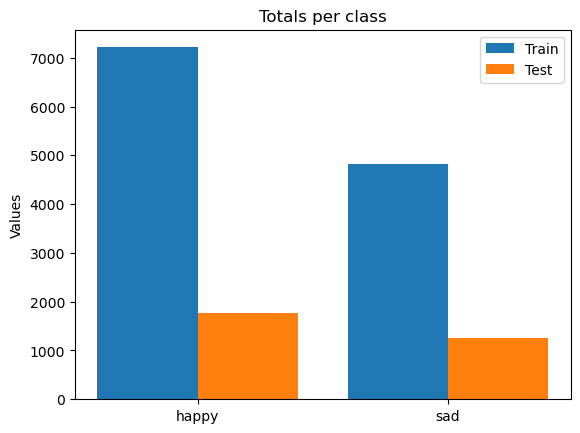

In [8]:
import numpy as np
import matplotlib.pyplot as plt

cats = classes # categories
vals1, vals2 = train_count, test_count

# Bar width and x locations
w, x = 0.4, np.arange(len(cats))

fig, ax = plt.subplots()

ax.bar(x - w/2, vals1, width=w, label='Train')
ax.bar(x + w/2, vals2, width=w, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_ylabel('Values')
ax.set_title('Totals per class')
ax.legend()

plt.show()

In [9]:
# Normalize
train_normalized = train.astype('float32') / 255.0
test_normalized = test.astype('float32') / 255.0

In [10]:
from tensorflow.keras.utils import to_categorical

# One hot encoding
test_labels_copy = test_labels # creates a copy of test
train_labels_categorical = to_categorical(train_labels, classes.shape[0])
test_labels_categorical = to_categorical(test_labels, classes.shape[0])

2025-06-10 18:42:30.443106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
print(train.shape)
print(test.shape)

(12045, 48, 48)
(3021, 48, 48)


In [12]:
from skimage.feature import hog

# HOG definition
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    for image in images:
        features, img = hog(image, orientations=9,      # Number of orientations to calculate the diagram 
                              pixels_per_cell=(8, 8),   # Image cells division
                              cells_per_block=(2, 2),   # Number of block cells. Used to improve light variance and contrast
                              visualize=True)           # Returns a hog image            
        hog_features.append(features)
        hog_images.append(img)
    return np.array(hog_features), hog_images

# Extract HOG characteristics from train and test data
train_hog, train_hog_images = extract_hog_features(train)
test_hog, _ = extract_hog_features(test)

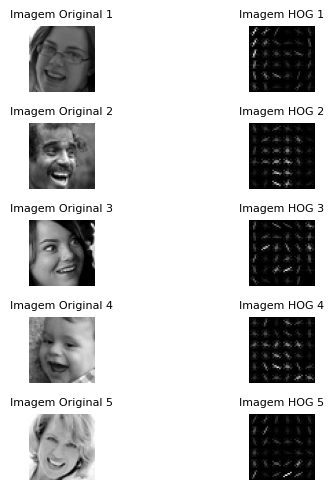

In [15]:
# Visualize HOG images
def visualize_multiple_hog(images, hog_images, images_to_show=5):
    plt.figure(figsize=(6, images_to_show))

    for i in range(images_to_show):
        # Original
        plt.subplot(images_to_show, 2, 2 * i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Original image {i+1}', fontsize=8)
        plt.axis('off')

        # HOG
        plt.subplot(images_to_show, 2, 2 * i + 2)
        plt.imshow(hog_images[i], cmap='gray')
        plt.title(f'HOG Image {i+1}', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

images_to_show = 5
visualize_multiple_hog(train, train_hog_images, images_to_show=images_to_show)

In [49]:
print(train_hog.shape)
print(test_hog.shape)

(12045, 900)
(3021, 900)


In [16]:
import tensorflow as tf

# Define the Artificial Neural Network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(train_hog.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(classes.shape[0], activation='softmax')  
])

# Compile model the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy', 
              metrics=['accuracy']
              )

2025-06-10 18:46:54.520729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               115328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 123,714
Trainable params: 123,714
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 4. Train the model (backpropagation happens here)
history = model.fit(train_hog, train_labels_categorical, epochs=100)

Epoch 1/100
377/377 [==============================] - 1s 2ms/step - loss: 0.6501 - accuracy: 0.6039
Epoch 2/100
377/377 [==============================] - 1s 2ms/step - loss: 0.5845 - accuracy: 0.6863
Epoch 3/100
377/377 [==============================] - 1s 2ms/step - loss: 0.5270 - accuracy: 0.7370
Epoch 4/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.7572
Epoch 5/100
377/377 [==============================] - 1s 1ms/step - loss: 0.4832 - accuracy: 0.7648
Epoch 6/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4748 - accuracy: 0.7682
Epoch 7/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4691 - accuracy: 0.7715
Epoch 8/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4630 - accuracy: 0.7729
Epoch 9/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4575 - accuracy: 0.7784
Epoch 10/100
377/377 [==============================] - 1s 2ms/step - loss: 0.4524 - accura

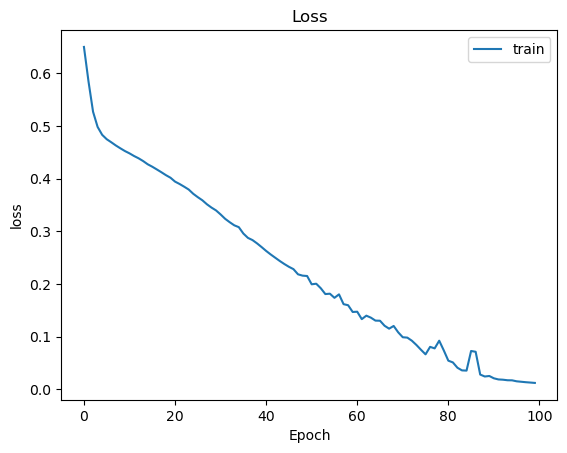

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend();

In [20]:
# 5. Evaluate the model
score = model.evaluate(test_hog, test_labels_categorical, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.6785449385643005
Test accuracy: 0.8205891847610474


In [21]:
# Predict results using test data
test_predicted = model.predict(test_hog)

95/95 [==============================] - 0s 1ms/step


In [22]:
threshold = 0.5 # defines the output threshold

test_predicted_flatten = []
test_labels_copy_text = []

test_predicted = np.where(test_predicted >= threshold, 1, 0)

# Build the confusion matrix data

classes_with_unknown = np.append(classes, 'unknown') # add non identified label
for row in range(test_predicted.shape[0]):
    for col in range(test_predicted.shape[1]):
        if test_predicted[row, col] == 1:
            test_predicted_flatten.append(classes_with_unknown[col])
            break
        elif col == test_predicted.shape[1] - 1: # if 
            test_predicted_flatten.append(classes_with_unknown[col + 1])

test_predicted_flatten = np.array(test_predicted_flatten)

for idx in test_labels_copy:
    test_labels_copy_text.append(classes[idx])
    
test_labels_copy_text = np.array(test_labels_copy_text)


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

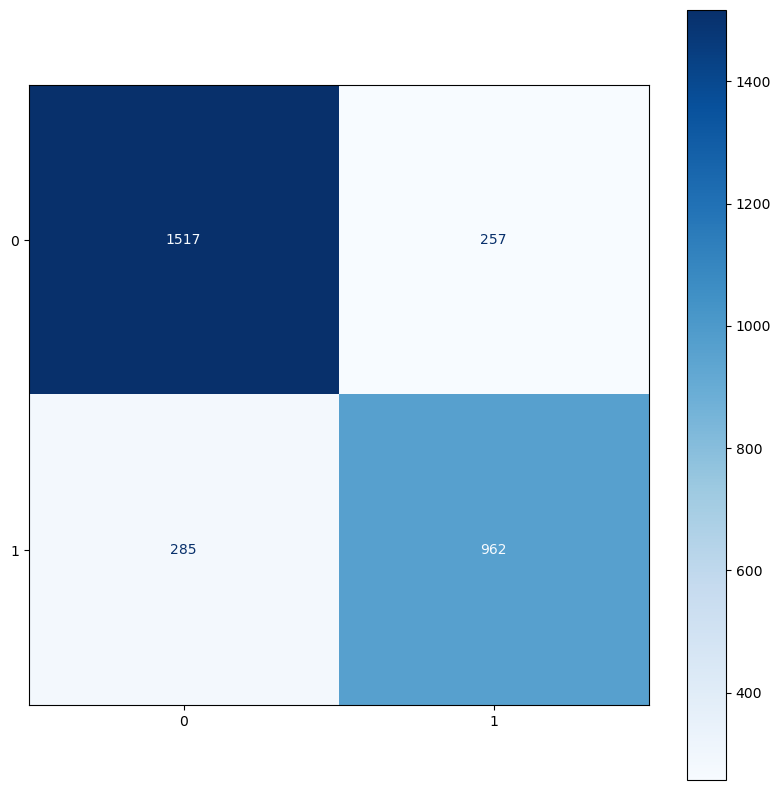

In [23]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Shows the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_labels_copy_text, test_predicted_flatten)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes_with_unknown)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()